In [1]:
import sys
import pickle
import numpy as np
import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
#tf.disable_eager_execution()
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

##### Set directory path of codes

In [4]:
new_path = r'/home/users/suihong/GANSimCodes/3. GANSimModel/' 
sys.path.append(new_path)

#### Set path to trained GANSim model

In [6]:

network_dir = '/scratch/users/suihong/GANSimData/TrainedModels/test_trained_GANSim/'
network_name = 'network-snapshot-007520.pkl' 

### 1. Import field reservoir data

In [9]:
# 1) Import probability cube for channel facies
# Read data exported from Petrel as a Gslib format.
# In the file the data are like following with I, J, K, wellfacies code (-99 means None)
# 1 1 1 -99.00 
# 2 1 1 -99.00 
# 3 1 1 -99.00 

prob_ch_path = '/scratch/users/suihong/GANSimData/Ref_ConditoingProbData_Channel_k5.txt' 
allele=[] 
with open(prob_ch_path, 'r') as f:
    i = 0
    for line in f:
        i = i + 1
        if i >=7:
            eles = line.strip().split(' ')
            allele.append(eles)
allfiledata = np.array(allele).reshape((-1, 4))
print(allfiledata.shape)
prob_ch = allfiledata[:, 3].reshape((1, 1, 100, 400, 400)).transpose(0,1,3, 4, 2) # -99 means none, 0 means noncave, 1 means cave
prob_ch = prob_ch[:,:,::-1,:,::-1].astype(np.float)
print(prob_ch.shape)
del allele

# 2) Import probability cube for lobe facies
prob_lobe_path = '/scratch/users/suihong/GANSimData/Ref_ConditoingProbData_Lobe_k5.txt' 
allele=[] 
with open(prob_lobe_path, 'r') as f:
    i = 0
    for line in f:
        i = i + 1
        if i >=7:
            eles = line.strip().split(' ')
            allele.append(eles)

allfiledata = np.array(allele).reshape((-1, 4))
print(allfiledata.shape)
prob_lobe = allfiledata[:, 3].reshape((1, 1, 100, 400, 400)).transpose(0,1,3, 4, 2) # -99 means none, 0 means noncave, 1 means cave
prob_lobe = prob_lobe[:,:,::-1,:,::-1].astype(np.float)
print(prob_lobe.shape)
del allele


(16000000, 4)
(1, 1, 400, 400, 100)
(16000000, 4)
(1, 1, 400, 400, 100)


In [10]:
# 3) Import well facies data exported from Petrel as a Gslib format.

well_path = '/scratch/users/suihong/GANSimData/Ref_ConditoingWellData.txt' 
allele=[] 
with open(well_path, 'r') as f:
    i = 0
    for line in f:
        i = i + 1
        if i >=7:
            eles = line.strip().split(' ')
            allele.append(eles)

allfiledata = np.array(allele).reshape((-1, 4))
print(allfiledata.shape)
welldata = allfiledata[:, 3].reshape((1, 1, 100, 400, 400)).transpose(0,1,3, 4, 2) # -99 means none, 0 means noncave, 1 means cave
welldata = welldata[:,:,::-1,:,::-1].astype(np.float)
print(welldata.shape)
del allele
del allfiledata

well_points = np.where(welldata == 255, 0, 1)
well_facies_types = np.where(welldata == 255, 0, welldata)
well_facies_input = np.concatenate([well_points, well_facies_types], 1)      
print(well_facies_input.shape)

(16000000, 4)
(1, 1, 400, 400, 100)
(1, 2, 400, 400, 100)


In [11]:
# Set trust level for probability cubes

# According to the reference geomodel, the proportion of mud facies is 84%, channel proportion is 3.5%, lobe proportion is 12.5%
# The facies proportion resulting from well data would be severely biased due to the locations of wells and the non-stationarity of turbidite sedimentology.
# We also dont know the actual facies proportions. Here, we assume mud proportion is 80%, channel proportion is 5%, and lobe proportion is 15%,
# Such values could be obtained from flume tank experiments, outcrop observations, or analyses of other reservoirs with similar sedimentary features.
# These three assumed values are then used as the priors here.

prior_mud = 0.80
pripor_ch = 0.05
pripor_lobe = 0.15

trust_level = 1.

prob_ch = trust_level * prob_ch + (1 - trust_level) * pripor_ch 
prob_lobe = trust_level * prob_lobe + (1 - trust_level) * pripor_lobe 


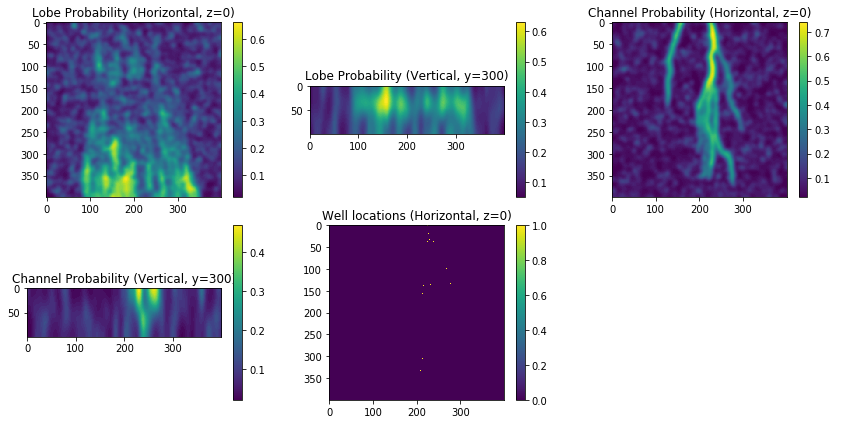

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(12, 6, forward=True)

# Horizontal section of lobe probability (z = 0)
im0 = ax[0, 0].imshow(prob_lobe[0, 0, :, :, 0].astype(np.float32))
ax[0, 0].set_title('Lobe Probability (Horizontal, z=0)')
fig.colorbar(im0, ax=ax[0, 0])

# Vertical section of lobe probability (y = 300), transpose for x-z view
im1 = ax[0, 1].imshow(prob_lobe[0, 0, 300, :, :].T.astype(np.float32))
ax[0, 1].set_title('Lobe Probability (Vertical, y=300)')
fig.colorbar(im1, ax=ax[0, 1])

# Horizontal section of channel probability (z = 0)
im2 = ax[0, 2].imshow(prob_ch[0, 0, :, :, 0].astype(np.float32))
ax[0, 2].set_title('Channel Probability (Horizontal, z=0)')
fig.colorbar(im2, ax=ax[0, 2])

# Vertical section of channel probability (y = 300), transpose for x-z view
im3 = ax[1, 0].imshow(prob_ch[0, 0, 300, :, :].T.astype(np.float32))
ax[1, 0].set_title('Channel Probability (Vertical, y=300)')
fig.colorbar(im3, ax=ax[1, 0])

# Horizontal section of well facies (z = 0)
im4 = ax[1, 1].imshow(well_facies_input[0, 0, :, :, 0].astype(np.float32))
ax[1, 1].set_title('Well locations (Horizontal, z=0)')
fig.colorbar(im4, ax=ax[1, 1])

# Turn off unused subplot
ax[1, 2].axis('off')

plt.tight_layout()
plt.show()


### 2. Import pre-trained Network

In [16]:
tf.InteractiveSession()
import dataset
with open(network_dir+network_name, 'rb') as file:
    G, D, Gs = pickle.load(file)  
del G

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [17]:
print(Gs.input_shapes)

print(Gs.output_shapes)

[[None, 8, 12, 12, 12], [None, 0, 12, 12, 12], [None, 2, 128, 128, 32], [None, 2, 128, 128, 32]]
[[None, 3, 128, 128, 32]]


### 3. Construction of a large generator

##### Since the field reservoir size (400x400x100 cells) is much larger than the generator's output size (128x128x32 cells), construct a new large generator and copy trainable parameters from the original trained small generator

In [18]:
tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
#tf.disable_eager_execution()
import config
import tfutil

# the relationship between resolutions and latent sizes are:
# x dimension: (latent_size_x - initCv_k + 1) * 128 / 4 = resolution_x; where, initCv_k is the kernel size of initial convolutional 
# layer and the default is 9 if not reset, 128 is the output size when training, and 4 is the feature map size after initial conv
# layer when training.
# y dimension: (latent_size_y - initCv_k + 1) * 128 / 4 = resolution_y;
# z dimension: (latent_size_z - initCv_k + 1) * 32 / 4 = resolution_z;
# All latent sizes should be no smaller than 12 which is used when training.

resolution_z = 104
resolution_x = 416
resolution_y = 416

latent_size_z = int(resolution_z/8 + 8)   # 21
latent_size_x = int(resolution_x/32 + 8)  # 21
latent_size_y = int(resolution_y/32 + 8)  # 21

label_size = 0
Gs_enlarged = tfutil.Network('Gs_enlarged1', label_size=label_size, 
                             resolution_z = resolution_z, resolution_x = resolution_x, resolution_y = resolution_y,
                             latent_size_z = latent_size_z, latent_size_x = latent_size_x, latent_size_y = latent_size_y,    
                             **config.G) 

Gs_enlarged.copy_trainables_from(Gs)

Instructions for updating:
non-resource variables are not supported in the long term


In [19]:
print(Gs_enlarged.input_shapes)
#Gs_enlarged.print_layers()

[[Dimension(None), Dimension(8), Dimension(21), Dimension(21), Dimension(21)], [Dimension(None), Dimension(0), Dimension(21), Dimension(21), Dimension(21)], [Dimension(None), Dimension(2), Dimension(416), Dimension(416), Dimension(104)], [Dimension(None), Dimension(2), Dimension(416), Dimension(416), Dimension(104)]]


### 4. Generation of multiple geomodel realizations 

In [20]:
## Expand conditioning data from 400x400x100 into 416x416x104

prob_lobe_el = np.concatenate((prob_lobe, prob_lobe[:, :, -16:][:,:,::-1]), axis = 2)
prob_lobe_el = np.concatenate((prob_lobe_el, prob_lobe_el[:, :, :, -16:][:,:,:, ::-1]), axis = 3)
prob_lobe_el = np.concatenate((prob_lobe_el, prob_lobe_el[:, :, :, :, -4:][:,:,:, :, ::-1]), axis = 4)
print(prob_lobe_el.shape)

prob_ch_el = np.concatenate((prob_ch, prob_ch[:, :, -16:][:,:,::-1]), axis = 2)
prob_ch_el = np.concatenate((prob_ch_el, prob_ch_el[:, :, :, -16:][:,:,:, ::-1]), axis = 3)
prob_ch_el = np.concatenate((prob_ch_el, prob_ch_el[:, :, :, :, -4:][:,:,:, :, ::-1]), axis = 4)
print(prob_ch_el.shape)

well_facies_input_el = np.concatenate((well_facies_input, well_facies_input[:, :, -16:][:,:,::-1]), axis = 2)
well_facies_input_el = np.concatenate((well_facies_input_el, well_facies_input_el[:, :, :, -16:][:,:,:, ::-1]), axis = 3)
well_facies_input_el = np.concatenate((well_facies_input_el, well_facies_input_el[:, :, :, :, -4:][:,:,:, :, ::-1]), axis = 4)
print(well_facies_input_el.shape)

(1, 1, 416, 416, 104)
(1, 1, 416, 416, 104)
(1, 2, 416, 416, 104)


In [21]:
realization_num = 50

prob_lobe_el_fp = np.flip(prob_lobe_el, 2)
prob_ch_el_fp = np.flip(prob_ch_el, 2)
well_facies_input_el_fp = np.flip(well_facies_input_el, 2)

latents = np.random.RandomState(9919).randn(realization_num, 8, latent_size_x, latent_size_y, latent_size_z)   #
labels = np.random.RandomState(816).randn(realization_num, 0, latent_size_x, latent_size_y, latent_size_z)  #
probs_input_mult = np.tile(np.concatenate((prob_ch_el_fp, prob_lobe_el_fp), axis = 1), [realization_num, 1, 1, 1, 1]).astype(np.float32)
well_facies_input_el_mult = np.tile(well_facies_input_el_fp, [realization_num, 1, 1, 1, 1]).astype(np.float32)

realization_indicators = np.zeros((realization_num, 3, 416, 416, 104), dtype = np.float32)
for i in range(realization_num):
    realization_indicators[i:i+1] = Gs_enlarged.run(latents[i:i+1], labels[i:i+1], well_facies_input_el_mult[i:i+1], probs_input_mult[i:i+1])
    print(i)    
realizations = np.expand_dims(np.argmax(realization_indicators, axis = 1), axis = 1)

realizations_fp = np.flip(realizations, axis = 2)
realizations_origsize = realizations_fp[:,:,:400,:400,:100]
print(realizations_origsize.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
(50, 1, 416, 416, 104)


##### Calculation of facies frequency cubes

In [31]:
freq_ch = np.mean(np.where(realizations_origsize == 1, 1, 0), axis = 0, keepdims = True)
print(freq_ch.shape)
freq_lobe = np.mean(np.where(realizations_origsize == 2, 1, 0), axis = 0, keepdims = True)
print(freq_lobe.shape)

(1, 1, 400, 400, 100)
(1, 1, 400, 400, 100)


##### Well facies reproduction accuracy

In [28]:
well_repro_acc = np.sum(np.where((realizations_origsize == well_facies_input[:, 1:2,:400,:400,:100]) & (well_facies_input[:, 0:1,:400,:400,:100] == 1.), 1., 0.)) / np.sum(well_facies_input[:, 0,:400,:400,:100]) / realization_num
print(well_repro_acc)

0.9974444444444444


##### Save generated facies models and frequency cubes as Gslib format to visualize in Petrel

In [29]:
##### Save 50 generated facies model realizations into Petrel-readable files

onecube = np.zeros([100, 400, 400])
coords = np.argwhere(onecube>-1)
coords_output = np.zeros(coords.shape)
coords_output[:,0] = coords[:,2]+1
coords_output[:,1] = coords[:,1]+1
coords_output[:,2] = 100 - coords[:,0]
coords_output = coords_output.astype(np.int16)

exampled_fm = realizations_origsize
exampled_fm_output = exampled_fm.transpose(0,1,4,2,3)[:,:,::-1,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.int)
exampled_fm_output_txt = np.concatenate((coords_output, exampled_fm_output), axis = 1)

exampled_fm_fname =network_dir + '50GeneatedFaciesModels_field_8160_k5.txt'
np.savetxt(exampled_fm_fname , exampled_fm_output_txt, fmt='%i', newline='\n')   # "%03d" + "%.10f"*7

with open(exampled_fm_fname, "r") as f:
    contents = f.readlines()
lines = 'PETREL: Properties\n'+'53\n'+'i_index unit1 scale1\n'+'j_index unit1 scale1\n'+'k_index unit1 scale1\n'+\
'Facies unit1 scale1\n'*50
contents.insert(0, lines)
with open(exampled_fm_fname, "w") as f:
    contents = "".join(contents)
    f.write(contents)

In [32]:
exampled_fm = np.concatenate((freq_ch, freq_lobe), axis = 0)
exampled_fm_output = exampled_fm.transpose(0,1,4,2,3)[:,:,::-1,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.float16)
exampled_fm_output_txt = np.concatenate((coords_output, exampled_fm_output), axis = 1)

exampled_fm_fname =network_dir + 'Frequency_field_8160_k5.txt'
np.savetxt(exampled_fm_fname , exampled_fm_output_txt, fmt="%03d " * 3 + "%.2f "*2, newline='\n')   # "%03d" + "%.10f"*7

with open(exampled_fm_fname, "r") as f:
    contents = f.readlines()
lines = 'PETREL: Properties\n'+'5\n'+'i_index unit1 scale1\n'+'j_index unit1 scale1\n'+'k_index unit1 scale1\n'+\
'Probability unit1 scale1\n'*2
contents.insert(0, lines)
with open(exampled_fm_fname, "w") as f:
    contents = "".join(contents)
    f.write(contents)